# Amazon Food Reviews
[Source from Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews#database.sqlite)

This dataset contains 568,454 reviews of food items on Amazon.$^1$ In this project, I will use this data to demonstrate key NLP tasks and techniques, but there are many other uses for this data including social network analysis.

<sub>1 When I looked for some of these reviews on Amazon.com, I couldn't find them (6 Aug 2018)</sub>

## Imports
Nothing too out of the ordinary.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.metrics import confusion_matrix

## Reading the data
For now it is contained in a repo in this directory as a csv file. After reading it in, look at the shape and top of the dataframe to make sure it loaded.

In [2]:
df = pd.read_csv("./data/Reviews.csv", index_col=0)

In [3]:
df.shape

(568454, 9)

In [4]:
df.head(2)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


## Get validation data
Right off the bat, reserve 10% for validation after all modeling is done. I don't want to use `train_test_split` because there isn't a set target yet.

In [5]:
# Set a validation size as 10% of the total data (round down)
val_size = int(df.shape[0]* 0.1)

In [6]:
# Randomly select from the index
np.random.seed(11010)
val_index = np.sort(np.random.choice(df.index, size = val_size, replace = False, ))

In [7]:
print(val_index)

[    17     22     40 ..., 568409 568430 568452]


In [8]:
# And the rest of the data is set in a new index
notval_index = set(df.index) - set(val_index)

In [9]:
# Assign the rows by index to the two dataframes
val = df.loc[val_index, :]

In [10]:
df = df.loc[notval_index, :]

In [11]:
print("Number of rows in new dataframe: ", df.shape[0])

Number of rows in new dataframe:  511609


In [12]:
print("Number of rows in validation dataframe: ",val.shape[0])

Number of rows in validation dataframe:  56845


## EDA
What are the data types in the set? (`object` means string in the pandas context)

In [13]:
df.dtypes

ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

`ProductId` and `UserId` are hashes. Let's check to be sure that for every unique `UserId` we get the same `ProfileName`. (The number of unique user IDs should be greater than or equal to the number of unique profile names, assuming that it's possible for people to choose non-unique profile names.)

In [15]:
print("There are {} unique user IDs.".format(len(df['UserId'].unique())))
print("There are {} unique profile names. ".format(len(df['ProfileName'].unique())))

There are 238026 unique user IDs.
There are 203756 unique profile names. 


In [16]:
df['UserId'].describe()

count             511609
unique            238026
top       A3OXHLG6DIBRW8
freq                 401
Name: UserId, dtype: object

In [17]:
i = 0
for l in df.groupby('UserId')['ProfileName'].unique():
    if len(l) != 1:
        i += 1
print(f"There are {i} user Ids with more than one associated profile name.")

There are 46 user Ids with more than one associated profile name.


Of the user Ids with more than one associated user name, there are always 2 names. Either one of them is 'A Customer', or the two names are somewhat plausibly related (initials versus full name, or some kind of website, for example.)

Helpfulness is a measure of how users rate a review by clicking either helpful or not helpful. This is expressed on the website as `X of Y users found this review helpful`. I'd rather know how many users clicked each option, so I'm going to translate the numerator and denominator to ups and downs.

In [18]:
df[['HelpfulnessNumerator', 'HelpfulnessDenominator']].head()

,HelpfulnessNumerator,HelpfulnessDenominator
Id,,
1,1,1
2,0,0
3,1,1
4,3,3
5,0,0


In [19]:
df['Helpful_rating'] = df['HelpfulnessNumerator']
df['Unhelpful_rating'] = df['HelpfulnessDenominator'] - df['HelpfulnessNumerator']
df.drop(['HelpfulnessNumerator', 'HelpfulnessDenominator'], axis=1, inplace=True)

In [21]:
df['Summary_length'] = df['Summary'].map(lambda x: len(str(x)))

In [22]:
df.head(2)

,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Helpful_rating,Unhelpful_rating,Summary_length
Id,,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,0,21
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,0,17


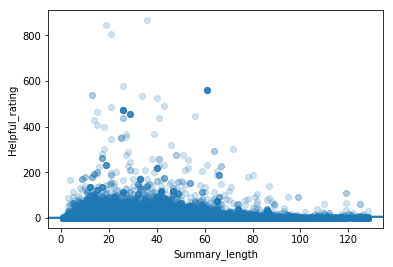

In [24]:
sns.regplot(x = 'Summary_length', y = 'Helpful_rating', data = df, scatter_kws={'alpha': 0.2})

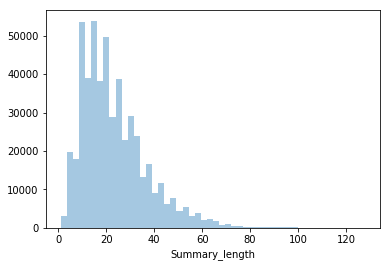

In [25]:
sns.distplot(df['Summary_length'], kde = False)

In [26]:
df[df['Helpful_rating'] == df['Helpful_rating'].max()]

,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Helpful_rating,Unhelpful_rating,Summary_length
Id,,,,,,,,,,
190734,B000FI4O90,A1GQGYROVZVW49,P. Schmidt,5,1164672000,Works as Advertised - Classy Product,see update at end of review<br /><br />*******...,866,12,36


In [27]:
df.loc[190734, 'Text'][69:216]

'I was lamenting about only having frech lettuce, herbs, chives, and tomatoes from may garden during the long fall-winter-spring parts of the year. '

In [28]:
df['Score'].describe()

count    511609.000000
mean          4.183089
std           1.310103
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64

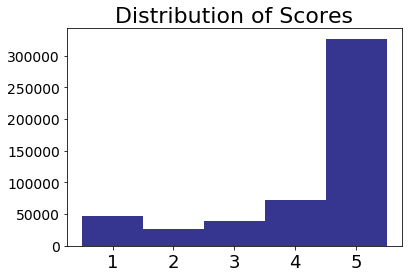

In [29]:
plt.bar(x = df.groupby('Score')['Summary'].count().index, 
        height = df.groupby('Score')['Summary'].count().values,
        width = 1,
        color = 'xkcd:deep blue',
        alpha = 0.8)

plt.title("Distribution of Scores", fontsize = 22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 14)
plt.show()

## Getting X and y
For fun, I could extract some features from `ProfileName` and try to use that to predict how helpful a score they give. Since this isn't super serious, I'm going to pick 5 or not 5 as a new categorical target variable.

In [34]:
df['Helpful_rating'].describe()

count    511609.000000
mean          1.742612
std           7.669413
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         866.000000
Name: Helpful_rating, dtype: float64

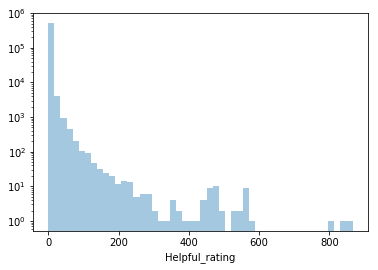

In [36]:
sns.distplot(df['Helpful_rating'], kde = False, hist_kws={'log': True})

In [37]:
df['helpful_not_zero'] = df['Helpful_rating'].map(lambda x: 1 if x != 0 else 0)

In [31]:
df['score_5'] = df['Score'].map(lambda x: 1 if x == 5 else 0)

([<matplotlib.axis.XTick at 0x1a1bb18f60>,
 <a list of 2 Text xticklabel objects>)

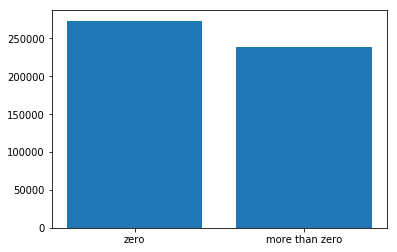

In [39]:
plt.bar(x = df.groupby('helpful_not_zero')['Summary'].count().index, 
        height = df.groupby('helpful_not_zero')['Summary'].count().values)
plt.xticks([0,1], ['zero', 'more than zero'])

([<matplotlib.axis.XTick at 0x1a1574a0b8>,
 <a list of 2 Text xticklabel objects>)

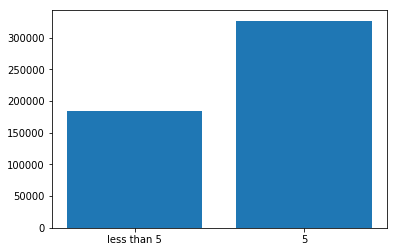

In [32]:
plt.bar(x = df.groupby('score_5')['Summary'].count().index, 
        height = df.groupby('score_5')['Summary'].count().values)
plt.xticks([0,1], ['less than 5', '5'])

Idea #1: usernames with quotes in them might be more or less helpful.

In [40]:
df['has_quotes'] = df['ProfileName'].str.contains('"').map(lambda x: 1 if x else 0)

Text(0.5,1,'Quotes and Helpfulness\n')

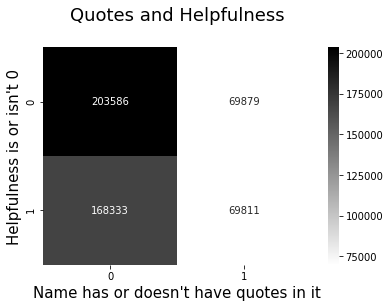

In [48]:
sns.heatmap(confusion_matrix(df['helpful_not_zero'], df['has_quotes']), annot = True, fmt = 'g', cmap = 'binary')
plt.ylabel("Helpfulness is or isn't 0", fontsize = 15)
plt.xlabel("Name has or doesn't have quotes in it", fontsize = 15)
plt.title("Quotes and Helpfulness\n", fontsize = 18)

Text(0.5,1,'Quotes and Score\n')

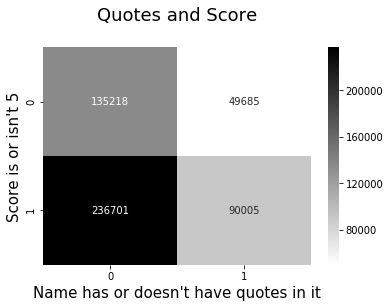

In [47]:
sns.heatmap(confusion_matrix(df['score_5'], df['has_quotes']), annot = True, fmt = 'g', cmap = 'binary')
plt.ylabel("Score is or isn't 5", fontsize = 15)
plt.xlabel("Name has or doesn't have quotes in it", fontsize = 15)
plt.title("Quotes and Score\n", fontsize = 18)

In [56]:
no_quotes_no_five = df[(df['has_quotes'] == 0 ) & (df['score_5'] == 0 )].shape[0]
no_quotes_yes_five = df[(df['has_quotes'] == 0 ) & (df['score_5'] == 1 )].shape[0]
yes_quotes_no_five = df[(df['has_quotes'] == 1 ) & (df['score_5'] == 0 )].shape[0]
yes_quotes_yes_five = df[(df['has_quotes'] == 1 ) & (df['score_5'] == 1 )].shape[0]

no_quotes_total = df[(df['has_quotes'] == 0 )].shape[0]
yes_quotes_total = df[(df['has_quotes'] == 1 )].shape[0]

print("Has no quotes in name and didn't give a 5: ".ljust(45), no_quotes_no_five)
print("Has no quotes in name and gave a 5: ".ljust(45), no_quotes_yes_five)
print("Has quotes in name and didn't give a 5: ".ljust(46), yes_quotes_no_five)
print("Has quotes in name and gave a 5: ".ljust(46), yes_quotes_yes_five)
print()
print("{:.2%} of users with quotes in their name gave a five-star rating.".format(yes_quotes_yes_five/yes_quotes_total))
print("{:.2%} of users without quotes in their name gave a five-star rating.".format(no_quotes_yes_five/no_quotes_total))

Has no quotes in name and didn't give a 5:    135218
Has no quotes in name and gave a 5:           236701
Has quotes in name and didn't give a 5:        49685
Has quotes in name and gave a 5:               90005

64.43% of users with quotes in their name gave a five-star rating.
63.64% of users without quotes in their name gave a five-star rating.


In [58]:
no_quotes_not_helpful = df[(df['has_quotes'] == 0 ) & (df['helpful_not_zero'] == 0 )].shape[0]
no_quotes_yes_helpful = df[(df['has_quotes'] == 0 ) & (df['helpful_not_zero'] == 1 )].shape[0]
yes_quotes_not_helpful = df[(df['has_quotes'] == 1 ) & (df['helpful_not_zero'] == 0 )].shape[0]
yes_quotes_yes_helpful = df[(df['has_quotes'] == 1 ) & (df['helpful_not_zero'] == 1 )].shape[0]

print("Has no quotes in name and got a zero in helpfulness: ".ljust(65), no_quotes_not_helpful)
print("Has no quotes in name and got above zero in helpfulness: ".ljust(65), no_quotes_yes_helpful)
print("Has quotes in name and got a zero in helpfulness: ".ljust(66), yes_quotes_not_helpful)
print("Has quotes in name and got above zero in helpfulness: ".ljust(66), yes_quotes_yes_helpful)
print()
print("{:.2%} of users with quotes in their name were helpful.".format(yes_quotes_yes_helpful/yes_quotes_total))
print("{:.2%} of users without quotes in their name were helpful.".format(no_quotes_yes_helpful/no_quotes_total))

Has no quotes in name and got a zero in helpfulness:              203586
Has no quotes in name and got above zero in helpfulness:          168333
Has quotes in name and got a zero in helpfulness:                  69879
Has quotes in name and got above zero in helpfulness:              69811

49.98% of users with quotes in their name were helpful.
45.26% of users without quotes in their name were helpful.


OK, so this isn't really paying off. How about checking to see if a username fits the pattern First M. Last?

In [65]:
def full_name_check(text):
    pattern = r"\b[A-Z][a-z]+ [A-Z]. [A-Z][a-z]+"
    if re.match(pattern=pattern, string=str(text)) != None:
        return 1
    else:
        return 0

In [66]:
df['is_fullname'] = df['ProfileName'].map(full_name_check)

In [68]:
no_fullname_not_helpful = df[(df['is_fullname'] == 0 ) & (df['helpful_not_zero'] == 0 )].shape[0]
no_fullname_yes_helpful = df[(df['is_fullname'] == 0 ) & (df['helpful_not_zero'] == 1 )].shape[0]
yes_fullname_not_helpful = df[(df['is_fullname'] == 1 ) & (df['helpful_not_zero'] == 0 )].shape[0]
yes_fullname_yes_helpful = df[(df['is_fullname'] == 1 ) & (df['helpful_not_zero'] == 1 )].shape[0]

no_fullname_total = df[df['is_fullname'] == 0].shape[0]
yes_fullname_total = df[df['is_fullname'] == 1].shape[0]

print("Not a fullname, got a zero in helpfulness: ".ljust(65), no_fullname_not_helpful)
print("Not a fullname, got above zero in helpfulness: ".ljust(65), no_fullname_yes_helpful)
print("Fullname, got a zero in helpfulness: ".ljust(66), yes_fullname_not_helpful)
print("Fullname, got above zero in helpfulness: ".ljust(66), yes_fullname_yes_helpful)
print()
print("{:.2%} of users with full names were helpful.".format(yes_fullname_yes_helpful/yes_fullname_total))
print("{:.2%} of users without full names were helpful.".format(no_fullname_yes_helpful/no_fullname_total))

Not a fullname, got a zero in helpfulness:                        249459
Not a fullname, got above zero in helpfulness:                    215989
Fullname, got a zero in helpfulness:                               24006
Fullname, got above zero in helpfulness:                           22155

48.00% of users with full names were helpful.
46.40% of users without full names were helpful.


In [69]:
no_fullname_not_five = df[(df['is_fullname'] == 0 ) & (df['score_5'] == 0 )].shape[0]
no_fullname_yes_five = df[(df['is_fullname'] == 0 ) & (df['score_5'] == 1 )].shape[0]
yes_fullname_not_five = df[(df['is_fullname'] == 1 ) & (df['score_5'] == 0 )].shape[0]
yes_fullname_yes_five = df[(df['is_fullname'] == 1 ) & (df['score_5'] == 1 )].shape[0]

no_fullname_total = df[df['is_fullname'] == 0].shape[0]
yes_fullname_total = df[df['is_fullname'] == 1].shape[0]

print("Not a fullname, gave below 5 stars: ".ljust(65), no_fullname_not_five)
print("Not a fullname, gave 5 stars: ".ljust(65), no_fullname_yes_five)
print("Fullname, gave below 5 stars: ".ljust(66), yes_fullname_not_five)
print("Fullname, gave 5 stars: ".ljust(66), yes_fullname_yes_five)
print()
print("{:.2%} of users with full names gave 5 stars.".format(yes_fullname_yes_five/yes_fullname_total))
print("{:.2%} of users without full names gave 5 stars.".format(no_fullname_yes_five/no_fullname_total))

Not a fullname, gave below 5 stars:                               169889
Not a fullname, gave 5 stars:                                     295559
Fullname, gave below 5 stars:                                      15014
Fullname, gave 5 stars:                                            31147

67.47% of users with full names gave 5 stars.
63.50% of users without full names gave 5 stars.


Next, what about if there aren't very many vowels in a username? It's more likely to be a random "kewl" username and not someone's real name. Do users who prize anonymity behave and/or are treated differently?

In [84]:
def vowel_counter(text):
    vowels = {'a', 'e', 'i', 'o', 'u'}
    count = 0
    for letter in str(text):
        if letter.lower() in vowels:
            count += 1
    return count

In [86]:
df['vowels_in_profilename'] = df['ProfileName'].map(vowel_counter)

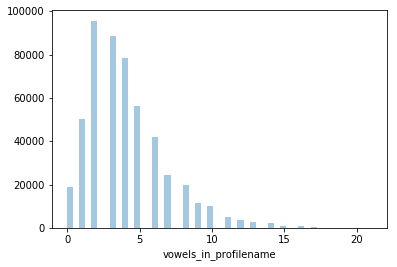

In [88]:
sns.distplot(df['vowels_in_profilename'], kde = False)

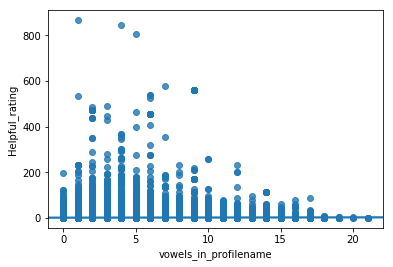

In [89]:
sns.regplot(x = 'vowels_in_profilename', y = 'Helpful_rating', data = df)